<a href="https://colab.research.google.com/github/Cordier-Info/Stats/blob/main/ACP%20pr%C3%A9noms.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ACP sur prénoms

In [1]:
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns 
import numpy as np 
import plotly.express as px
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

Dans Colab faut installer ces packages :

In [2]:
!apt install gdal-bin python-gdal python3-gdal 
!apt install python3-rtree 
!pip install -q git+git://github.com/geopandas/geopandas.git
!pip install -q contextily
!pip install -q mapclassify

Reading package lists... Done
Building dependency tree       
Reading state information... Done
gdal-bin is already the newest version (2.2.3+dfsg-2).
python-gdal is already the newest version (2.2.3+dfsg-2).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  python3-numpy
Suggested packages:
  python-numpy-doc python3-nose python3-numpy-dbg
The following NEW packages will be installed:
  python3-gdal python3-numpy
0 upgraded, 2 newly installed, 0 to remove and 34 not upgraded.
Need to get 2,288 kB of archives.
After this operation, 13.2 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/main amd64 python3-numpy amd64 1:1.13.3-2ubuntu1 [1,943 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 python3-gdal amd64 2.2.3+dfsg-2 [346 kB]
Fetched 2,288 kB in 1s (2,249 kB/s)
Selecting previously unselected

In [3]:
import contextily as cx
import mapclassify
import geopandas as gpd

## Importation des données et toilettage.

In [4]:
url = "http://cordier-phychi.toile-libre.org/Info/github/dpt2019.csv"
prenoms_data = pd.read_csv(url,sep=";")

choix :
- on ne s'occupe que des années de 2001 (`y_deb`) à 2019 (`y_fin`)
- on ne garde que les prénoms qui apparaissent au moins 50 (`nb_min`) fois. 

In [5]:
y_deb = 2001
y_fin = 2019
nb_min = 100

In [6]:
prenoms_data = prenoms_data[prenoms_data['preusuel']!='_PRENOMS_RARES']
prenoms_data = prenoms_data[~(prenoms_data['dpt']=="XX")]
prenoms_data['dpt'] = pd.to_numeric(prenoms_data['dpt'])
prenoms_data['annais'] = pd.to_numeric(prenoms_data['annais'])
prenoms_data = prenoms_data[prenoms_data["dpt"]<96]
prenoms_data = prenoms_data[prenoms_data["annais"]>=2001]
cumul_prenoms = prenoms_data.groupby(["preusuel"], as_index=False)["nombre"].agg('sum')
cumul_prenoms = cumul_prenoms[cumul_prenoms["nombre"]>nb_min]
prenoms_data = prenoms_data[prenoms_data['preusuel'].isin(cumul_prenoms['preusuel'])]

In [7]:
départements = pd.unique(prenoms_data["dpt"])
# Attention, la corse est le département 20 dans ces data (pas 2A et 2B)
a = prenoms_data.groupby(["preusuel", "dpt"], as_index=False)["nombre"].sum()
# on somme sur les années par prénom et par département

In [8]:
prénoms = pd.unique(prenoms_data["preusuel"])
print(f"{len(prénoms)} prénoms en tout")

2942 prénoms en tout


Fabrication d'une dataframe avec chaque prénom en colonne et les départements en index.

In [9]:
PRENOMS = pd.DataFrame(index = départements,columns = prénoms)
for i in range(len(a)) :
    dep = a.loc[i, "dpt"]
    pren = a.loc[i, "preusuel"]
    nb = a.loc[i, "nombre"]
    PRENOMS.loc[dep,pren]=nb
PRENOMS = PRENOMS.fillna(0) # NaN -> 0
PRENOMS = PRENOMS.sort_index()
PRENOMS

,AARON,ABD,ABDALLAH,ABDEL,ABDELKADER,ABDELKARIM,ABDELLAH,ABDELMALIK,ABDELRAHMAN,ABDERAHMANE,ABDERRAHMAN,ABDERRAHMANE,ABDOU,ABDOUL,ABDOULAYE,ABDOULLAH,ABDULLAH,ABEL,ABOU,ABOUBACAR,ABOUBAKAR,ABRAHAM,ACHILLE,ACHRAF,ADAM,ADAMA,ADAME,ADAN,ADEL,ADEM,ADEN,ADIL,ADNANE,ADONIS,ADRIAN,ADRIANO,ADRIEL,ADRIEN,AEDAN,AHMAD,...,YASMINE,YELENA,YLANA,YLIANA,YLONA,YNES,YOUMNA,YOUNA,YOUSRA,YOUSSRA,YSALINE,YSEE,YSÉE,YUNA,ZAHRA,ZAINA,ZAÏNA,ZAINAB,ZAINEB,ZARA,ZAYNAB,ZAYNEB,ZEHRA,ZEINAB,ZEINEB,ZELIA,ZÉLIA,ZELIE,ZÉLIE,ZEYNAB,ZEYNEB,ZEYNEP,ZIA,ZINA,ZINEB,ZOE,ZOÉ,ZOË,ZOHRA,ZOLA
1,147,0,7,0,0,0,0,0,0,0,0,0,0,0,0,0,3,6,0,0,0,0,0,0,276,0,0,0,3,25,0,4,0,0,0,0,0,178,0,0,...,95,0,0,0,0,0,0,0,3,0,3,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,14,0,3,17,0,0,3,9,253,0,0,0
2,213,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,17,0,0,0,0,21,0,260,0,0,0,3,13,0,4,0,3,0,0,0,242,0,0,...,73,4,3,0,0,0,0,0,4,3,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,3,18,47,0,0,3,0,0,3,21,504,0,0,0
3,125,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,15,0,0,0,0,9,0,130,0,0,3,0,3,0,0,0,0,0,0,0,170,0,0,...,29,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,16,0,0,0,0,0,0,20,246,0,0,0
4,53,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,65,0,0,0,0,3,0,0,0,0,3,0,0,26,0,0,...,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,38,0,0,0
5,40,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,45,0,0,0,0,6,0,0,0,0,0,0,0,55,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,7,10,0,0,0,0,0,0,7,97,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,565,0,88,10,9,0,3,3,0,0,6,3,6,20,131,0,21,67,7,47,29,9,30,10,1418,111,29,7,92,218,14,70,6,8,50,35,12,548,18,10,...,589,6,6,9,9,3,14,0,77,20,0,3,0,26,36,0,0,3,3,0,16,30,3,3,0,0,0,17,19,15,15,61,6,10,29,25,666,0,8,3
92,774,19,215,44,44,6,71,3,10,3,19,54,22,25,107,12,19,210,4,55,26,24,315,27,3789,107,83,29,249,341,40,110,6,13,159,23,10,1403,24,41,...,1240,10,0,3,0,4,18,6,153,62,7,3,32,67,112,17,9,0,0,8,48,48,0,9,7,6,0,47,95,16,26,3,11,18,89,71,1256,6,30,0
93,643,33,335,98,109,23,94,12,33,34,36,111,58,83,431,56,114,148,28,234,138,41,48,48,3556,383,107,23,350,643,20,227,27,0,111,30,5,434,0,68,...,1776,7,0,10,3,12,19,0,273,94,0,0,0,31,230,20,11,42,34,44,113,111,15,67,33,0,0,20,27,58,92,113,0,42,130,6,481,0,85,0
94,742,3,162,26,44,0,27,6,3,6,4,30,18,37,180,6,21,107,6,97,47,15,56,10,2281,141,59,15,179,312,32,91,12,9,106,30,3,688,17,42,...,835,6,7,10,0,7,13,0,132,26,0,0,6,37,83,0,3,4,6,12,37,45,0,3,7,0,0,22,43,22,17,21,0,3,44,62,654,0,31,0


## Traitement statistique

On standardise les données (centrées réduites).

In [10]:
scaler = StandardScaler()
X = scaler.fit_transform(PRENOMS)

On opère l'ACP :

In [11]:
pca = PCA()
components = pca.fit_transform(X)

In [12]:
taille = 30 #exp_var_cumul.shape[0] + 1
exp_var_cumul = np.cumsum(pca.explained_variance_ratio_)
fig = px.bar(x=range(1, taille+1),y=pca.explained_variance_ratio_[:taille],labels={"x": "composante", "y": "% variance expliquée"},template="none")
fig.add_scatter(x=list(range(1, taille+1)), y=exp_var_cumul[:taille], name="", showlegend=False)

On va garder 15 composantes :

In [13]:
nb_c = 15
pca = PCA(n_components = nb_c)
pca.fit(X)
score_pca = pca.transform(X)

In [14]:
PRENOMS[[f"composante {i}" for i in range(1,nb_c+1)]] = pd.DataFrame(score_pca, index=PRENOMS.index)
PRENOMS.head(3)

,AARON,ABD,ABDALLAH,ABDEL,ABDELKADER,ABDELKARIM,ABDELLAH,ABDELMALIK,ABDELRAHMAN,ABDERAHMANE,ABDERRAHMAN,ABDERRAHMANE,ABDOU,ABDOUL,ABDOULAYE,ABDOULLAH,ABDULLAH,ABEL,ABOU,ABOUBACAR,ABOUBAKAR,ABRAHAM,ACHILLE,ACHRAF,ADAM,ADAMA,ADAME,ADAN,ADEL,ADEM,ADEN,ADIL,ADNANE,ADONIS,ADRIAN,ADRIANO,ADRIEL,ADRIEN,AEDAN,AHMAD,...,ZAINA,ZAÏNA,ZAINAB,ZAINEB,ZARA,ZAYNAB,ZAYNEB,ZEHRA,ZEINAB,ZEINEB,ZELIA,ZÉLIA,ZELIE,ZÉLIE,ZEYNAB,ZEYNEB,ZEYNEP,ZIA,ZINA,ZINEB,ZOE,ZOÉ,ZOË,ZOHRA,ZOLA,composante 1,composante 2,composante 3,composante 4,composante 5,composante 6,composante 7,composante 8,composante 9,composante 10,composante 11,composante 12,composante 13,composante 14,composante 15
1,147,0,7,0,0,0,0,0,0,0,0,0,0,0,0,0,3,6,0,0,0,0,0,0,276,0,0,0,3,25,0,4,0,0,0,0,0,178,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,14,0,3,17,0,0,3,9,253,0,0,0,-19.703403,-3.286740,-1.646415,0.075337,-0.776924,4.904162,0.627324,-1.863987,0.022903,0.008616,-0.028196,-0.489558,-0.334269,-0.471465,-0.699257
2,213,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,17,0,0,0,0,21,0,260,0,0,0,3,13,0,4,0,3,0,0,0,242,0,0,...,0,0,0,0,0,0,0,0,0,0,0,3,18,47,0,0,3,0,0,3,21,504,0,0,0,-13.707862,4.388355,1.595237,-4.626288,-2.152964,1.251571,-1.646871,0.716601,-2.235299,-2.011740,-1.963654,-1.151230,-1.752711,2.636934,1.781548
3,125,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,15,0,0,0,0,9,0,130,0,0,3,0,3,0,0,0,0,0,0,0,170,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,3,16,0,0,0,0,0,0,20,246,0,0,0,-21.278596,-2.738861,0.776074,-2.245047,-2.682563,0.127462,1.254415,0.263991,-0.666038,-0.830497,-0.475858,-1.022511,-0.039091,0.280968,-0.169860


In [15]:
decomp = pd.DataFrame(pca.components_.T, columns=[f"composante {i}" for i in range(1,nb_c+1)], index=PRENOMS.columns.values[:-nb_c])
decomp

,composante 1,composante 2,composante 3,composante 4,composante 5,composante 6,composante 7,composante 8,composante 9,composante 10,composante 11,composante 12,composante 13,composante 14,composante 15
AARON,0.024015,0.004143,0.004144,0.010984,0.006290,-0.008190,-0.020285,0.003991,-0.012997,-0.000126,-0.001455,-0.004124,-0.016116,-0.005625,0.003684
ABD,0.017777,-0.010667,-0.015103,0.031208,-0.009673,0.010673,0.053575,-0.009022,0.017447,-0.039969,-0.005445,-0.002147,0.002232,0.008528,0.027494
ABDALLAH,0.021639,-0.007107,-0.024735,0.001429,0.004410,0.005924,0.032528,0.017917,0.002680,-0.009905,-0.009715,-0.004885,0.018285,-0.001181,0.010890
ABDEL,0.020640,-0.010718,-0.021151,0.010441,-0.008467,-0.002415,0.039064,-0.013005,0.017598,-0.025287,0.003386,-0.003672,0.016510,0.012623,0.015986
ABDELKADER,0.020154,-0.003842,-0.026425,0.020619,-0.016500,-0.014445,0.016860,-0.015497,0.011029,-0.003827,0.015610,-0.007015,0.026165,0.005124,0.017897
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZOE,0.015740,0.008345,0.014384,0.027580,-0.021507,-0.013575,-0.043759,-0.016553,-0.005924,-0.019257,0.020361,-0.013333,0.083576,-0.003368,0.044665
ZOÉ,0.020762,0.023036,0.017805,-0.005954,0.008413,0.013784,-0.006931,0.001942,0.004637,-0.007573,0.008989,0.000728,-0.013288,0.020918,0.003275
ZOË,0.015661,0.025482,0.019922,-0.024200,-0.014648,-0.009061,0.003210,-0.012420,0.007103,0.007904,0.006024,-0.000092,0.020547,-0.004609,-0.003823
ZOHRA,0.022572,-0.004048,-0.018021,0.002311,-0.010355,-0.002523,0.026907,-0.017961,0.013842,-0.017864,-0.004898,-0.006345,0.016217,-0.004105,0.015108


Fonction permettant l'affichage des premiers et derniers prénoms sur une composante donnée :

In [16]:
def recap(composante) :
    i_comp = composante
    nb_prenoms = 100
    indices = indices = [i+j*100 for j in range(4) for i in range(10)]
    tab_recap = pd.DataFrame(index = indices,columns = ["premiers","valeur+","derniers","valeur-"])
    tri_haut = decomp.sort_values(by= f"composante {i_comp}",ascending=False)
    tri_bas = decomp.sort_values(by= f"composante {i_comp}",ascending=True)
    for i in indices :
        tab_recap.loc[i,"premiers"] = tri_haut.index[i]
        tab_recap.loc[i,"valeur+"] = tri_haut.iloc[i,i_comp-1]
        tab_recap.loc[i,"derniers"] = tri_bas.index[i]
        tab_recap.loc[i,"valeur-"] = tri_bas.iloc[i,i_comp-1]
    return tab_recap

## Affichage sur une carte

Récupération et toilettage des données géographiques :

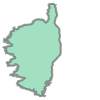

In [17]:
corse = gpd.read_file('http://cordier-phychi.toile-libre.org/Info/github/corse.geojson')
corse['geometry'][0]

In [18]:
dp_data = gpd.read_file('http://cordier-phychi.toile-libre.org/Info/github/departements.geojson')
dp_data.drop(columns='nom',inplace=True)
dp_data.at[28, 'code'] = 20
dp_data.at[28, 'geometry'] = corse['geometry'][0]
dp_data = dp_data[~(dp_data['code']=="2B")]
dp_data['code'] = pd.to_numeric(dp_data['code'])
dp_data = dp_data.sort_values(by="code",ascending=True)
dp_data = dp_data.set_index('code')

In [19]:
PRENOMS_LOC = dp_data.merge(PRENOMS, left_index=True, right_index=True)

In [20]:
def carte_comp(composante) :
    ax = PRENOMS_LOC.plot(figsize = (30,10), alpha=0.8, column = f"composante {composante}", cmap = "viridis", legend=True)
    ax.axis('off')
    return ax

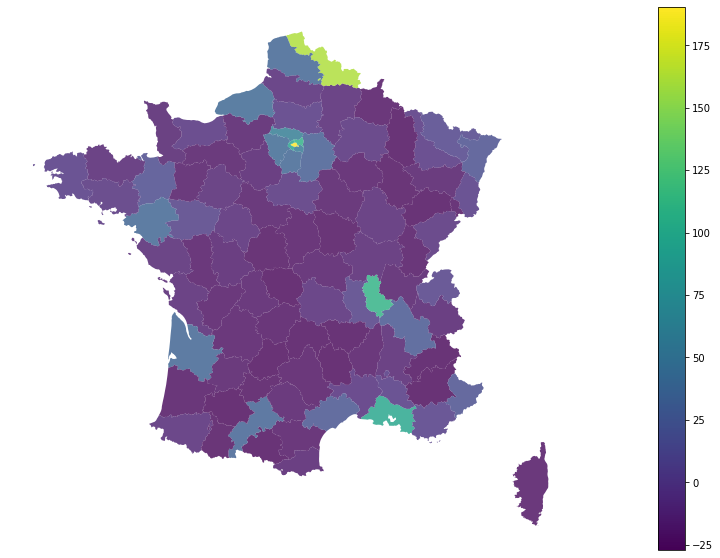

In [21]:
carte_comp(composante = 1)

In [22]:
recap(composante = 1)

,premiers,valeur+,derniers,valeur-
0,SARAH,0.0247507,PETRU,-0.00144417
1,INÈS,0.0245868,FRANCESCU,-0.00144417
2,EDEN,0.0244332,MARC'ANDRIA,-0.00144417
3,ISAAC,0.0242401,ANGE-MARIE,-0.00144417
4,SANDRA,0.024172,SAVERIU,-0.00144417
5,RUBEN,0.0241589,SAVERIA,-0.00128799
6,ADAM,0.0241387,MATTEU,-0.0012007
7,ELODIE,0.0240931,JORDI,-0.00112119
8,SOFIA,0.0240555,CHJARA,-0.000978294
9,WILLIAM,0.0240464,ANDRIA,-0.000969997


Valeur d'un prénom donné sur les composantes en places par rapport au max ou au min :

In [24]:
px.bar(x=list(range(1,16)),y=decomp.loc['LUC',:])

Carte de la répartition d'un prénom (données standardisées)

In [25]:
PRENOMS_STD = pd.DataFrame(X,columns=PRENOMS.columns[:-nb_c])
PRENOMS_STD.index = range(1,96)
PRENOMS_STD_LOC = dp_data.merge(PRENOMS_STD, left_index=True, right_index=True)

In [26]:
def carte_prenom(prenom) :
    PRENOM = prenom.upper()
    ax = PRENOMS_STD_LOC.plot(figsize = (30,10), alpha=0.8, column = PRENOM, cmap = "viridis", legend=True)
    ax.axis('off')
    return ax

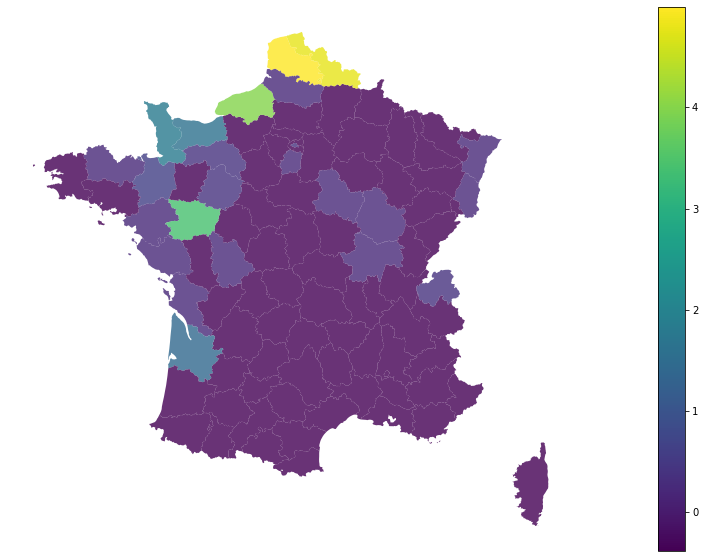

In [28]:
carte_prenom(prenom = 'zola')

Effectifs et répartition d'un prénom :

In [29]:
Prenom = 'zola'.upper()
PRENOMS.sort_values(by=Prenom,ascending=False)[Prenom].head(5)

62    27
59    26
76    22
49    19
50    11
Name: ZOLA, dtype: int64